### Open File

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('./data/df_features.gz')

### Create Predicted Category for final models (2 categories)

In [3]:
# Creo estasdisticos por hotel para introducir en el modelo, ya que cada hotel se comporta de manera distina
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [4]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [5]:
category = np.array(['Bad' if i < 7 else 'Good' for i in df.Reviewer_Score])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df)

Good    0.831599
Bad     0.168401
Name: Category, dtype: float64

### Balance Nationalities and / or Categories

In [6]:
def balance_df(df, Balance_Nationality, Balance_Category, cut):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = cut
            if len(nationality) < n:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [7]:
df_balanced_1 = balance_df(df, Balance_Nationality=False, Balance_Category=True, cut=10000)
df_balanced_2 = balance_df(df_balanced_1, Balance_Nationality=True, Balance_Category=True, 
                         cut=int(np.median(df_balanced_1.Nationality_Recode.value_counts())*1.5))
df_balanced_2.shape

(77270, 78)

In [8]:
df_balanced_2.Nationality_Recode.value_counts()

North America          11829
UK & Ireland           11810
Western Europe         11809
Middle east            11761
Eastern Europe          9058
Asia & Pacific          7869
Oceania                 7555
Sub-Saharian Africa     2023
South/Latin America     1614
China                   1127
Arab States              815
Name: Nationality_Recode, dtype: int64

### Prepare Data to run Models

In [9]:
df_model = df_balanced_2.sample(n=50000, random_state=1)
df_model.shape

(50000, 78)

In [10]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','count', 'mean', 'std', 'min', '25%', 
               '50%', '75%', 'max']

x_col = x_categorical + x_numerical
y_col = 'Category'

In [11]:
X_numerical = df_model[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [12]:
# Recodifico las varariables categoricas en features distintas binarias.
df_model['Review_Month'] = df_model['Review_Month'].astype(str)
X_categorical = pd.get_dummies(df_model[x_categorical], prefix_sep='_', drop_first=False)
X_categorical = X_categorical.fillna('Not Available')

In [13]:
X = pd.concat([X_numerical_std, X_categorical], axis=1, sort=False)
y = df_model[y_col]

Now i only select the optimal features 

In [14]:
X = X[['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given',
       'room_Neg_Hotel', 'facilities_Neg_Hotel', 'staff_Pos_Hotel',
       'comfort_Pos_Hotel', 'mean', 'std', 'max', 'Review_Month_1',
       'Review_Month_10', 'Review_Month_12', 'Review_Month_2',
       'Review_Month_3', 'Review_Month_4', 'Review_Month_6', 'Review_Month_7',
       'Review_Month_8', 'Review_Month_9', 'City_Amsterdam', 'City_Barcelona',
       'City_London', 'City_Paris', 'Pet_With a pet', 'Purpose_Business trip',
       'Purpose_Leisure trip', 'Whom_Couple',
       'Whom_Family with older children', 'Whom_Family with young children',
       'Whom_Solo traveler', 'Whom_Travelers with friends',
       'Room_Recode_Deluxe', 'Room_Recode_Executive',
       'Room_Recode_Other (Standard)', 'Room_Recode_Studio',
       'Room_Recode_Suite', 'Nationality_Recode_Arab States',
       'Nationality_Recode_Asia & Pacific',
       'Nationality_Recode_Eastern Europe', 'Nationality_Recode_Middle east',
       'Nationality_Recode_North America', 'Nationality_Recode_Oceania',
       'Nationality_Recode_South/Latin America',
       'Nationality_Recode_Sub-Saharian Africa',
       'Nationality_Recode_UK & Ireland', 'Nationality_Recode_Western Europe',
       'Length_Recode_Stayed 2 nights', 'Length_Recode_Stayed 6 nights',
       'Length_Recode_Stayed 7 nights', 'Length_Recode_Stayed 8 nights',
       'Length_Recode_Stayed 9+ nights', 'Stars_Pension',
       'Stars_hotel de 3 estrellas']]

Split into Train and Test

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [16]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((10000, 53), (10000,), (40000, 53), (40000,))

## MODELS

### Evaluate Model

In [17]:
import time
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score, make_scorer
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials, space_eval

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [19]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [20]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    clf = model
    clf.fit(X_train, y_train)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [22]:
def evaluate_grid(model, params, X_train, X_test, y_train, y_test, verbose = 1):
    f1 = make_scorer(f1_score, pos_label = "Bad")
    clf = GridSearchCV(estimator = model, param_grid = params, n_jobs = -1, cv = 5, scoring = f1, verbose = verbose)    
    clf.fit(X_train, y_train)
    print(clf.best_params_, clf.best_score_)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [23]:
def print_result(clf, X_train, X_test, y_train, y_test):
    print('Accuracy Test :', f'{accuracy_score(clf.predict(X_test), y_test):.4f}', 
          '| F1 Test :', f'{f1_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}',
          '| Precision Test :', f'{precision_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}', 
          '| H Test :', f'{H_score(clf.predict(X_test), y_test):.4f}')
    
    print('Accuracy Train:', f'{accuracy_score(clf.predict(X_train), y_train):.4f}', 
          '| F1 Train:', f'{f1_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}',
          '| Precision Train:', f'{precision_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}', 
          '| H Train:', f'{H_score(clf.predict(X_train), y_train):.4f}')

In [24]:
def H_score(X_train, y_train):
    acc = accuracy_score(X_train, y_train)
    f1 = f1_score(X_train, y_train, pos_label = "Bad")
    return(2 / ((1/acc)+(1/f1)))

In [25]:
def bayesian(space, X, y, modelo, nevals):
    
    f1 = make_scorer(f1_score, pos_label = "Bad")

    def objective(space):        
        global best_score
        model = modelo(**space, random_state = 1)   
        cv =  StratifiedKFold(n_splits = 5, random_state = 1)
        score = -cross_val_score(model, X, y, cv = cv, scoring = f1, verbose = False).mean()
        if (score < best_score):
            best_score = score
        return score

    start = time.time()
    rstate = np.random.RandomState(1)
    best = fmin(
      objective, 
      space = space,
      algo = tpe.suggest, 
      max_evals = nevals,
      trials = Trials(),
      rstate = rstate)

    print("Hyperopt search took %.2f seconds for 200 candidates" % ((time.time() - start)))
    print("Best score: %.4f " % (-best_score))
    print("Best space: ", space_eval(params, best))
    return(space_eval(params, best))

### KNN (KDTree Implementation)

In [26]:
from collections import Counter
from sklearn.neighbors import KDTree
tree = KDTree(X_train)

In [27]:
nearest_dist, nearest_ind = tree.query(X_test, k = 105)

In [28]:
pred_knn = [Counter([y_train.iloc[k] for k in x]).most_common(1)[0][0] for x in nearest_ind]

### Gradient Boosted Trees

In [29]:
params = {'learning_rate':     hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 
                                                          0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.50]), 
          'n_estimators':      hp.choice('n_estimators', range(1,400)),
          'max_depth':         hp.choice('max_depth',range(1,20)),
          'min_samples_split': hp.choice('min_samples_split',np.linspace(0.01, 1.0, 10, endpoint=True)),
          'min_samples_leaf':  hp.choice('min_samples_leaf',np.linspace(0.01, 0.5, 50, endpoint=True)), 
          'subsample':         hp.choice('subsample',[1]), 
          'max_features':      hp.choice('max_features',['sqrt'])}

best_score = 1
gbt_params = bayesian(params, X_train, y_train, GradientBoostingClassifier, 25)
pred_gbt = evaluate_model(GradientBoostingClassifier(**gbt_params), X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [06:41<00:00, 16.06s/trial, best loss: -0.6631194989914556]
Hyperopt search took 401.72 seconds for 200 candidates
Best score: 0.6631 
Best space:  {'learning_rate': 0.025, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 0.06999999999999999, 'min_samples_split': 0.01, 'n_estimators': 195, 'subsample': 1}
Accuracy Test : 0.6552 | F1 Test : 0.6624 | Precision Test : 0.6765 | H Test : 0.6588
Accuracy Train: 0.6601 | F1 Train: 0.6677 | Precision Train: 0.6833 | H Train: 0.6639


### Random Forest

In [30]:
params = {'bootstrap':         hp.choice('bootstrap',[True, False]),
          'max_depth':         hp.choice('max_depth', range(1, 20)),
          'max_features':      hp.choice('max_features',['auto', 'sqrt']),
          'min_samples_leaf':  hp.choice('min_samples_leaf',np.linspace(0.01, 0.5, 50, endpoint=True)), 
          'min_samples_split': hp.choice('min_samples_split',np.linspace(0.01, 1.0, 100, endpoint=True)), 
          'n_estimators':      hp.choice('n_estimators',range(1,400))}

best_score = 1
rf_params = bayesian(params, X_train, y_train, RandomForestClassifier, 50)
pred_rf = evaluate_model(RandomForestClassifier(**rf_params), X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [10:00<00:00, 12.01s/trial, best loss: -0.6665999944439813]
Hyperopt search took 600.49 seconds for 200 candidates
Best score: 0.6666 
Best space:  {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.7000000000000001, 'n_estimators': 82}


C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


Accuracy Test : 0.5001 | F1 Test : 0.0000 | Precision Test : 0.0000 | H Test : 0.0000
Accuracy Train: 0.5001 | F1 Train: 0.0000 | Precision Train: 0.0000 | H Train: 0.0000


C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


### XGBoosting

In [31]:
params = {'learning_rate':    hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
                                                         0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75]), 
          'max_depth':        hp.choice('max_depth',range(1,20)),
          'min_child_weight': hp.choice('min_child_weight',np.linspace(0.01, 1.0, 100, endpoint=True)),
          'gamma':            hp.choice('gamma',np.linspace(0.01, 1.0, 100, endpoint=True)), 
          'colsample_bytree': hp.choice('colsample_bytree',np.linspace(0.0, 1, 101, endpoint=True)), 
          'n_estimators':     hp.choice('n_estimators', range(1,200))}

best_score = 1
xgb_params = bayesian(params, X_train, y_train, xgb.XGBClassifier, 50)
pred_xgb = evaluate_model(xgb.XGBClassifier(**xgb_params), X_train, X_test, y_train, y_test)

 28%|███████████████████████████▍                                                                      | 14/50 [16:31<42:29, 70.83s/trial, best loss: -0.6646374662755388]


KeyboardInterrupt: 

### Logistic Regresion

In [ ]:
params = {"C":   hp.choice('C',[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]),
          ""
          "tol": hp.choice('tol',[0.00001, 0.000025, 0.00005, 0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 
                                  0.05, 0.1])}

best_score = 1
log_params = bayesian(params, X_train, y_train, LogisticRegression, 50)
pred_log = evaluate_model(LogisticRegression(**log_params, max_iter = 1000), X_train, X_test, y_train, y_test)

### Decision Trees

In [ ]:
params = {"max_depth":        hp.choice('max_depth', range(1, 20)),
          "max_features":     hp.choice('max_features', range(1, 50)),
          "min_samples_leaf": hp.choice('min_samples_leaf', range(1, 50)),
          "criterion":        hp.choice('criterion', ["gini", "entropy"])}

best_score = 1
tree_params = bayesian(params, X_train, y_train, DecisionTreeClassifier, 50)
pred_tree = evaluate_model(DecisionTreeClassifier(**tree_params), X_train, X_test, y_train, y_test)

### SVM

In [ ]:
params = {"degree": hp.choice('degree', [2, 3, 4]),
          "kernel": hp.choice('kernel', ['poly']), 
          "C":      hp.choice('C', [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
                                    0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75])}
best_score = 1
svm_params = bayesian(params, X_train, y_train, SVC, 10)
pred_svm = evaluate_model(SVC(**svm_params), X_train, X_test, y_train, y_test)

### Best Model (Logistic Regression)

In [111]:
pd.crosstab(pred_log, y_test)

Category,Bad,Good
row_0,,
Bad,3887,2075
Good,2125,3913


In [110]:
print('Accuracy: ',f'{accuracy_score(pred_log, y_test):.4f}')
print('F1-Score: ',f'{f1_score(pred_log, y_test, pos_label="Bad"):.4f}')
print('Precision:',f'{precision_score(pred_log, y_test, pos_label="Bad"):.4f}')

Accuracy:  0.6500
F1-Score:  0.6492
Precision: 0.6465


## CONFIDENCE INTERVAL

In [120]:
pred_ac = []
clf = LogisticRegression(**log_params, max_iter=1000)
clf.fit(X_train, y_train)

np.random.seed(1)
for i in range(1000):
    sample = np.random.randint(0, len(X_test), size=len(X_test))
    X_sample = X_test.iloc[sample]
    y_sample = y_test.iloc[sample]
    print(i, end='\r', flush=True)
    pred_ac.append(accuracy_score(clf.predict(X_sample), y_sample))

(array([  3.,   0.,   1.,   2.,   8.,  10.,  13.,  31.,  45.,  58.,  79.,
         88., 111., 123., 104.,  81.,  83.,  52.,  50.,  24.,  15.,  11.,
          6.,   1.,   1.]),
 array([0.63358333, 0.63479667, 0.63601   , 0.63722333, 0.63843667,
        0.63965   , 0.64086333, 0.64207667, 0.64329   , 0.64450333,
        0.64571667, 0.64693   , 0.64814333, 0.64935667, 0.65057   ,
        0.65178333, 0.65299667, 0.65421   , 0.65542333, 0.65663667,
        0.65785   , 0.65906333, 0.66027667, 0.66149   , 0.66270333,
        0.66391667]),
 <a list of 25 Patch objects>)

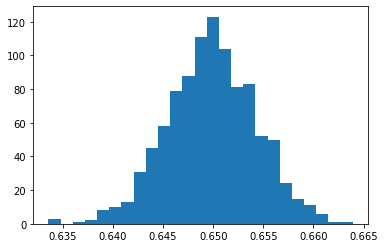

In [121]:
plt.hist(pred_ac, bins=25)

In [123]:
print('            0.5%    50%  99.5%')
print('Accuracy:',f'{np.percentile(pred_ac,0.5):.4f}',f'{np.percentile(pred_ac,50):.4f}',f'{np.percentile(pred_ac,99.5):.4f}')

            2.5%    50%  97.5%
Accuracy: 0.6383 0.6498 0.6609
